## Histopathologic Cancer Detection

### Imports

- Library Imports

In [73]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import keras
import os
import tensorflow as tf
import cv2

from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers.schedules import ExponentialDecay
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

from glob import glob

- Data Imports

In [15]:
path = "/Users/manuelportillo/coursera/ms_ai/csca_5624_intro_deep_learning/module3/kaggle_cancer_data/histopathologic-cancer-detection"

train_data = f"{path}/train/"
test_data = f"{path}/test/"

# import data and create dataframes
train = pd.DataFrame({'path': glob(os.path.join(train_data, '*.tif'))})
test = pd.DataFrame({'path': glob(os.path.join(test_data, '*.tif'))})
labels = pd.read_csv(f"{path}/train_labels.csv")
sample = pd.read_csv(f"{path}/sample_submission.csv")

### EDA

- Initial Data Cleaning

In [19]:
# Create id columns
train['id'] = train['path'].str.extract(r'([^//]+).tif$')
test['id'] = test['path'].str.extract(r'([^//]+).tif$')

# Add train labels
train = train.merge(labels, on='id')

In [25]:
# look at some of the train data
print(train.head())
print('\n')
print(train.info())

                                                path  \
0  /Users/manuelportillo/coursera/ms_ai/csca_5624...   
1  /Users/manuelportillo/coursera/ms_ai/csca_5624...   
2  /Users/manuelportillo/coursera/ms_ai/csca_5624...   
3  /Users/manuelportillo/coursera/ms_ai/csca_5624...   
4  /Users/manuelportillo/coursera/ms_ai/csca_5624...   

                                         id  label  
0  f0c2a0b8ef3024f407fa97d852d49be0215cafe0      0  
1  99ef485f205645918613cd04281098daa7c17819      1  
2  e2612e173abd0e8bb54a3c3db3f264b63d80bffb      1  
3  6d1bb57c0606f05dbd75f90a8d9e21a57e1267e0      0  
4  9c043ab2adadfeb758c71d21432fccd3e43565c0      1  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   path    220025 non-null  object
 1   id      220025 non-null  object
 2   label   220025 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 5.0+ M

In [58]:
# look at some of test data
print(test.head())

                                                path  \
0  /Users/manuelportillo/coursera/ms_ai/csca_5624...   
1  /Users/manuelportillo/coursera/ms_ai/csca_5624...   
2  /Users/manuelportillo/coursera/ms_ai/csca_5624...   
3  /Users/manuelportillo/coursera/ms_ai/csca_5624...   
4  /Users/manuelportillo/coursera/ms_ai/csca_5624...   

                                         id  
0  fd0a060ef9c30c9a83f6b4bfb568db74b099154d  
1  1f9ee06f06d329eb7902a2e03ab3835dd0484581  
2  19709bec800f372d0b1d085da6933dd3ef108846  
3  7a34fc34523063f13f0617f7518a0330f6187bd3  
4  93be720ca2b95fe2126cf2e1ed752bd759e9b0ed  


- Data visualization

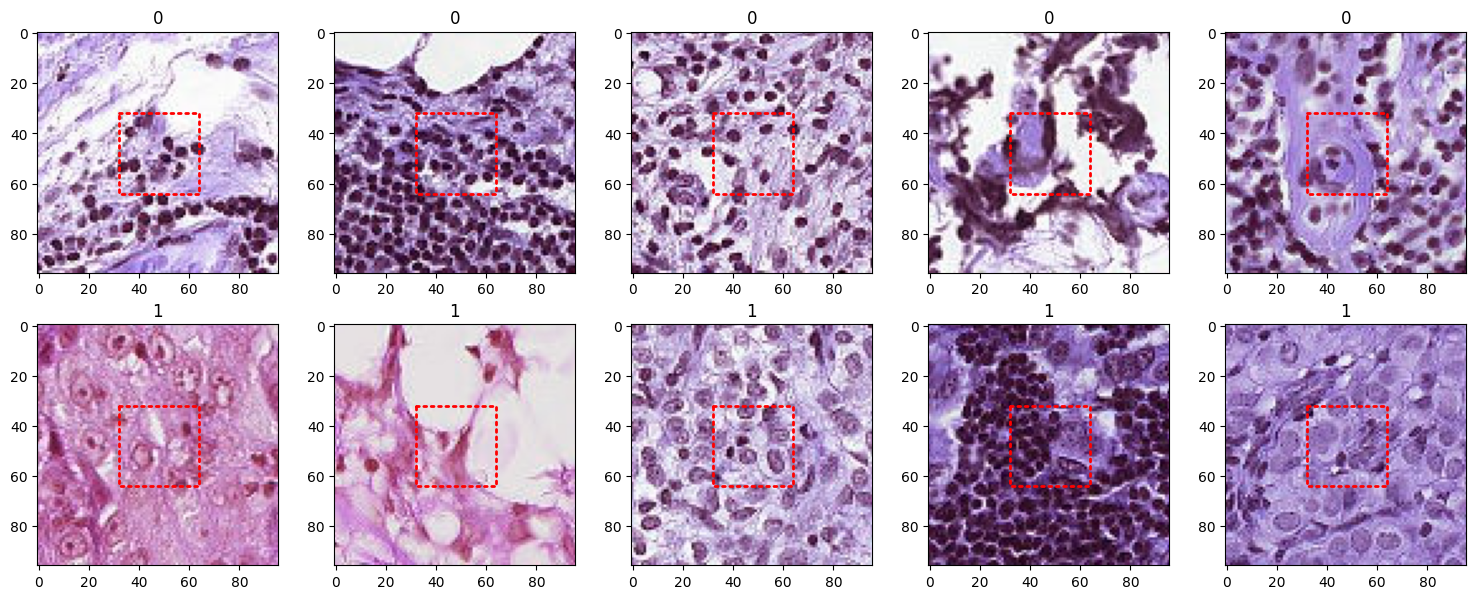

In [44]:
# function to create plots
def plts(label, num_cols, df):
    cats = (df.groupby([label])[label].nunique()).index

    f, ax = plt.subplots(nrows=len(cats), ncols=num_cols, figsize=(3 * num_cols, 3 * len(cats)))

    for i, cat in enumerate(cats):
        sample = df[df[label] == cat].sample(num_cols)
        for j in range(0, num_cols):
            file = sample.iloc[j]['path']
            img = cv2.imread(file)
            ax[i, j].imshow(img, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=12)
            # add box to zoom in on area determining label = 1
            box = patches.Rectangle((32, 32), 32, 32, linewidth=2, edgecolor='r', facecolor='none', linestyle=':', capstyle='round')
            ax[i, j].add_patch(box)

    plt.tight_layout()
    plt.show()

# plot samples for each label value
plts('label', 5, train)

- Data distribution

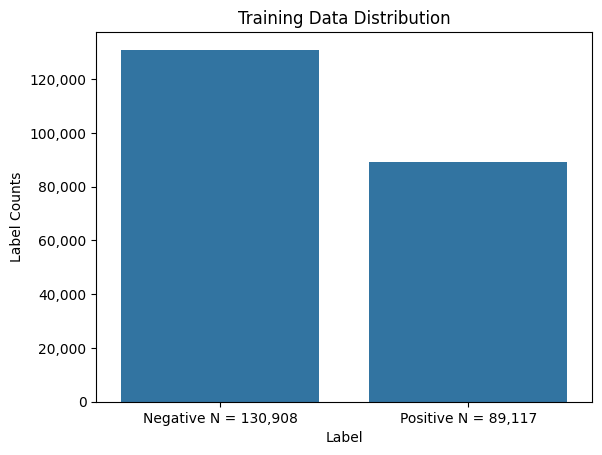

In [ ]:
# training data distribution
cnts = train['label'].value_counts()

ax = sns.barplot(x=cnts.index, y=cnts.values)
plt.xlabel('Label')
plt.ylabel('Label Counts')
ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.title('Training Data Distribution')
plt.xticks(ticks=[0, 1], labels=[f"Negative N = {train['label'].value_counts()[0]:,}", 
                                 f"Positive N = {train['label'].value_counts()[1]:,}"]); # The ";" at the end is to suppress some ugly printing

### Model Building

- Train/Validation split and Test data

In [61]:
# specify train/validation split to use
train_data, val_data = train_test_split(train, test_size=0.2, stratify=train['label'], random_state=42)

# convert label column to string
train_data['label'] = train_data['label'].astype(str)
val_data['label'] = val_data['label'].astype(str)

# generate required datasets
datagen = ImageDataGenerator(rescale = 1/255)
train_gen = datagen.flow_from_dataframe(dataframe=train_data
                                        ,directory=f"{path}/train"
                                        ,x_col='path'
                                        ,y_col='label'
                                        ,target_size=(96,96)
                                        ,batch_size=40
                                        ,class_mode='binary'
                                        )

val_gen = datagen.flow_from_dataframe(dataframe=val_data
                                        ,directory=f"{path}/train"
                                        ,x_col='path'
                                        ,y_col='label'
                                        ,target_size=(96,96)
                                        ,batch_size=40
                                        ,class_mode='binary'
                                        )

test_gen = datagen.flow_from_dataframe(dataframe=test
                                        ,directory=f"{path}/test"
                                        ,x_col='path'
                                        ,y_col=None
                                        ,target_size=(96,96)
                                        ,batch_size=40
                                        ,class_mode=None
                                        )

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Found 57458 validated image filenames.


- CNN model hyperparameters:
1. learning rate = 0.001
2. optimization method = Adam
3. hidden layer activation function = ReLU
4. number of filters = 32 first layer, 64 second layer, 128 third layer
5. filter size = (3 ,3)
6. stride = 1
7. padding = maintain 'same' dimension as input
8. max pool size = (2, 2)
9. output layer activation function = sigmoid
10. regularization = batch normalization, dropout


In [62]:
# specify hyperparameter values:
lr = 0.001
l1_filter = 32
l2_filter = 64
l3_filter = 128
filter_size = (3, 3)
padding = 'same'
max_pool = (2, 2)
h_activation = 'relu'
o_activation = 'sigmoid'
dropout = 0.2

- build CNN model

In [68]:
model = Sequential()

# Feature extraction/Convolution layers
# layer 1
model.add(Conv2D(l1_filter, filter_size, padding=padding, activation=h_activation, input_shape=(96, 96, 3)))
model.add(BatchNormalization())
model.add(Conv2D(l1_filter, filter_size, padding=padding, activation=h_activation))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=max_pool))
model.add(Dropout(dropout))

# layer 2
model.add(Conv2D(l2_filter, filter_size, padding=padding, activation=h_activation))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=max_pool))
model.add(Dropout(dropout))

# layer 3
model.add(Conv2D(l3_filter, filter_size, padding=padding, activation=h_activation))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=max_pool))
model.add(Dropout(dropout))

# Classifier layer
model.add(Flatten())
model.add(Dense(128, h_activation))
model.add(Dense(128, h_activation))
model.add(Dense(1, o_activation))

model.summary()

/Users/manuelportillo/coursera/ms_ai/csca_5624_intro_deep_learning/c5624/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 96, 96, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,479,585 (9.46 MB)

 Trainable params: 2,479,073 (9.46 MB)

 Non-trainable params: 512 (2.00 KB)

- learning rate schedule

In [71]:
sch_steps = 1000
lr_sch = ExponentialDecay(lr, sch_steps, 0.8, staircase=True)

- Train the model

In [75]:
model.compile(optimizer=Adam(learning_rate = lr_sch)
              ,loss='binary_crossentropy'
              ,metrics=['accuracy'])

- Fit the model

In [77]:
model_hist = model.fit(train_gen, validation_data=val_gen, epochs=10, batch_size=64, verbose=1)

Epoch 1/10
4401/4401 ━━━━━━━━━━━━━━━━━━━━ 608s 138ms/step - accuracy: 0.8666 - loss: 0.3174 - val_accuracy: 0.8508 - val_loss: 0.4406
Epoch 2/10
4401/4401 ━━━━━━━━━━━━━━━━━━━━ 628s 143ms/step - accuracy: 0.9151 - loss: 0.2158 - val_accuracy: 0.8794 - val_loss: 0.4210
Epoch 3/10
4401/4401 ━━━━━━━━━━━━━━━━━━━━ 630s 143ms/step - accuracy: 0.9321 - loss: 0.1759 - val_accuracy: 0.9210 - val_loss: 0.2180
Epoch 4/10
4401/4401 ━━━━━━━━━━━━━━━━━━━━ 639s 145ms/step - accuracy: 0.9396 - loss: 0.1571 - val_accuracy: 0.9337 - val_loss: 0.1910
Epoch 5/10
4401/4401 ━━━━━━━━━━━━━━━━━━━━ 646s 147ms/step - accuracy: 0.9427 - loss: 0.1503 - val_accuracy: 0.9276 - val_loss: 0.2058
Epoch 6/10
4401/4401 ━━━━━━━━━━━━━━━━━━━━ 654s 148ms/step - accuracy: 0.9432 - loss: 0.1474 - val_accuracy: 0.9281 - val_loss: 0.2030
Epoch 7/10
4401/4401 ━━━━━━━━━━━━━━━━━━━━ 639s 145ms/step - accuracy: 0.9448 - loss: 0.1450 - val_accuracy: 0.9273 - val_loss: 0.2067
Epoch 8/10
4401/4401 ━━━━━━━━━━━━━━━━━━━━ 638s 145ms/step - ac

- Model evaluation

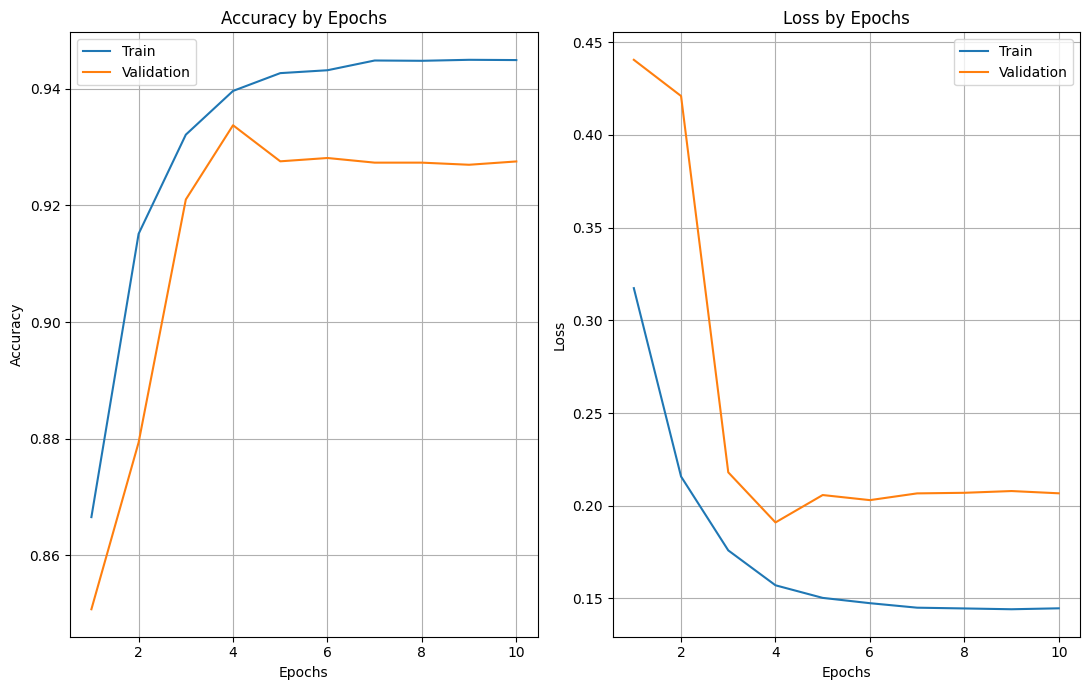

In [84]:
# plot the loss and accuracy across epochs
plt.figure(figsize=(11, 7))

# accuracy
epochs = range(1, len(model_hist.history['accuracy']) + 1)
plt.subplot(1, 2, 1)
plt.plot(epochs, model_hist.history['accuracy'], label='Train')
plt.plot(epochs, model_hist.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy by Epochs')
plt.legend()
plt.grid(True)

# loss
plt.subplot(1, 2, 2)
plt.plot(epochs, model_hist.history['loss'], label='Train')
plt.plot(epochs, model_hist.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss by Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Test results for Kaggle submission

- score the test data and create submission file

In [86]:
# test score
test_preds = model.predict(test_gen, verbose=1)

1437/1437 ━━━━━━━━━━━━━━━━━━━━ 34s 24ms/step


In [87]:
test.head()

,path,id
0,/Users/manuelportillo/coursera/ms_ai/csca_5624...,fd0a060ef9c30c9a83f6b4bfb568db74b099154d
1,/Users/manuelportillo/coursera/ms_ai/csca_5624...,1f9ee06f06d329eb7902a2e03ab3835dd0484581
2,/Users/manuelportillo/coursera/ms_ai/csca_5624...,19709bec800f372d0b1d085da6933dd3ef108846
3,/Users/manuelportillo/coursera/ms_ai/csca_5624...,7a34fc34523063f13f0617f7518a0330f6187bd3
4,/Users/manuelportillo/coursera/ms_ai/csca_5624...,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed


In [88]:
# prep submission file
k_submit = test.copy()
k_submit = k_submit[['id']]
k_submit['label'] = test_preds

In [89]:
# look at some of the data
k_submit.head()

,id,label
0,fd0a060ef9c30c9a83f6b4bfb568db74b099154d,0.972446
1,1f9ee06f06d329eb7902a2e03ab3835dd0484581,0.999755
2,19709bec800f372d0b1d085da6933dd3ef108846,0.999994
3,7a34fc34523063f13f0617f7518a0330f6187bd3,0.985688
4,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed,0.000919


In [90]:
# send to csv
k_submit.to_csv('cnn_submission.csv', index=False)

- Kaggle submission score

![Model Submission](./mp_cnn_model_submission.png)

### Conclusion

The CNN model I developed performed reasonably well using a CNN architecture with three convolutional layers. The accuracy of the model is 0.94, but the accuracy from the Kaggle submission is 0.5, indicating a reasonable performance on the model training but poor performance on the test data - this could be due to model overfitting. Additionally, as demonstrated by the accuracy plots on the training, there are minimal gains expected from further increases to the number of epochs used as the accuracy has plateaued by around the eight epoch. However, there is drop in the validation performance around the fourth epoch, which could be impacting the Kaggle score.

That said, there are approaches that could be used to improve on the model. For instance:
- Transfer learning was not tested. It is possible that pre-trained models exist that could fit this data well and improve the model performance.
- More convolutional layers can be tested
- The number of filters used could be modified to find one with better performance
- Different padding and stride combinations could be tested - in my model, stride is left at 1, which resulted in the model taking about 10 minutes to run for each epoch
- A metric other than accuracy could be used, for example, AUC, which could result in different performance

Overall, I believe the model performs reasonably well, and the exercise of fitting a CNN to this data reinforced the steps required to build this type of model.